In [1]:
!pip install -q tensorflow
!pip install -q protobuf
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.5 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 202

In [2]:
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import matplotlib.pyplot as plt

2025-11-10 12:59:39.696401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762779580.019737      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762779580.107434      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# 📁 Chemin du dossier de base
base = "/kaggle/input/imdb-review"
print("📂 Contenu du dossier de base :", os.listdir(base))

# 📁 Dossiers train et test
train_dir = os.path.join(base, "aclImdb", "train")
test_dir = os.path.join(base, "aclImdb", "test")

print("\n📂 Contenu du dossier train :", os.listdir(train_dir))
print("\n📂 Contenu du dossier test :", os.listdir(test_dir))

# 📁 Sous-dossiers positifs et négatifs
train_pos_dir = os.path.join(train_dir, "pos")
train_neg_dir = os.path.join(train_dir, "neg")

test_pos_dir = os.path.join(test_dir, "pos")
test_neg_dir = os.path.join(test_dir, "neg")

print("\n📄 Exemple de fichiers positifs (train) :", os.listdir(train_pos_dir)[:5])
print("\n📄 Exemple de fichiers négatifs (train) :", os.listdir(train_neg_dir)[:5])

# ✅ Vérification du nombre de fichiers
print("\nNombre de fichiers positifs (train) :", len(os.listdir(train_pos_dir)))
print("Nombre de fichiers négatifs (train) :", len(os.listdir(train_neg_dir)))
print("Nombre de fichiers positifs (test) :", len(os.listdir(test_pos_dir)))
print("Nombre de fichiers négatifs (test) :", len(os.listdir(test_neg_dir)))

📂 Contenu du dossier de base : ['aclImdb']

📂 Contenu du dossier train : ['pos', 'labeledBow.feat', 'urls_pos.txt', 'neg', 'unsupBow.feat', 'unsup', 'urls_neg.txt', 'urls_unsup.txt']

📂 Contenu du dossier test : ['pos', 'labeledBow.feat', 'urls_pos.txt', 'neg', 'urls_neg.txt']

📄 Exemple de fichiers positifs (train) : ['2714_10.txt', '589_10.txt', '2211_8.txt', '2658_10.txt', '8929_8.txt']

📄 Exemple de fichiers négatifs (train) : ['3606_2.txt', '1074_4.txt', '4743_1.txt', '7628_1.txt', '6812_1.txt']

Nombre de fichiers positifs (train) : 12500
Nombre de fichiers négatifs (train) : 12500
Nombre de fichiers positifs (test) : 12500
Nombre de fichiers négatifs (test) : 12500


In [4]:

# Initialisation des listes pour stocker les labels et les textes
labels = []
texts = []

# Boucle sur les types de labels 'neg' (négatif) et 'pos' (positif)
for label_type in ['neg', 'pos']:
    # Création du chemin vers le répertoire correspondant au type de label
    dir_name = os.path.join(train_dir, label_type)
    print(dir_name)  # Affichage du chemin du répertoire pour vérification
    # Boucle sur les fichiers du répertoire
    for fname in os.listdir(dir_name):
        # Vérifie si le fichier se termine par '.txt'
        if fname[-4:] == '.txt':
            # Ouverture du fichier en lecture
            f = open(os.path.join(dir_name, fname))
            # Lecture du contenu du fichier et ajout à la liste des textes
            texts.append(f.read())
            # Fermeture du fichier
            f.close()
            # Ajout du label correspondant (0 pour 'neg', 1 pour 'pos')
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


/kaggle/input/imdb-review/aclImdb/train/neg
/kaggle/input/imdb-review/aclImdb/train/pos


In [5]:
maxlen = 100  # Nous allons couper les critiques après 100 mots
training_samples = 200  # Nous allons entraîner le modèle sur 200 échantillons
validation_samples = 10000  # Nous allons valider le modèle sur 10 000 échantillons
max_words = 10000  # Nous allons considérer uniquement les 10 000 mots les plus fréquents du dataset

# Initialisation du tokenizer de Keras pour les 10 000 mots les plus fréquents
tokenizer = Tokenizer(num_words=max_words)
# Ajustement du tokenizer sur les textes
tokenizer.fit_on_texts(texts)
# Conversion des textes en séquences de tokens
sequences = tokenizer.texts_to_sequences(texts)

# Récupération de l'index des mots
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))  # Affiche le nombre de tokens uniques trouvés

Found 88582 unique tokens.


In [6]:
# Remplissage des séquences pour qu'elles aient toutes la même longueur (100 mots)
data = pad_sequences(sequences, maxlen=maxlen)

# Conversion des labels en tableau numpy
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)  # Affiche la forme du tenseur de données
print('Shape of label tensor:', labels.shape)  # Affiche la forme du tenseur de labels

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [7]:

# Séparation des données en un ensemble d'entraînement et un ensemble de validation
# Mais d'abord, mélange des données car les échantillons sont ordonnés (d'abord tous les négatifs, puis tous les positifs)
indices = np.arange(data.shape[0])  # Création d'un tableau d'indices
np.random.shuffle(indices)  # Mélange des indices
data = data[indices]  # Réorganisation des données selon les indices mélangés
labels = labels[indices]  # Réorganisation des labels selon les indices mélangés

# Séparation des données en ensemble d'entraînement et ensemble de validation
x_train = data[:training_samples]  # Les 200 premiers échantillons pour l'entraînement
y_train = labels[:training_samples]  # Les 200 premiers labels pour l'entraînement
x_val = data[training_samples: training_samples + validation_samples]  # Les 10 000 échantillons suivants pour la validation
y_val = labels[training_samples: training_samples + validation_samples]  # Les 10 000 labels suivants pour la validation


In [8]:
# Télécharger le fichier glove.6B.100d.txt.zip depuis le site de Stanford NLP
# Utilisation de curl pour télécharger le fichier et le renommer en glove.6B.100d.txt.zip
!curl -Lo glove.6B.100d.txt.zip https://nlp.stanford.edu/data/glove.6B.zip

# Décompresser le fichier téléchargé pour extraire glove.6B.100d.txt
# L'option -j permet d'extraire seulement le fichier glove.6B.100d.txt sans recréer les répertoires internes
!unzip -j glove.6B.100d.txt.zip glove.6B.100d.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   346    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  822M  100  822M    0     0  5266k      0  0:02:39  0:02:39 --:--:-- 5216k  0  0:02:21  0:00:19  0:02:02 5072k
Archive:  glove.6B.100d.txt.zip
  inflating: glove.6B.100d.txt       


In [11]:
# Initialisation d'un dictionnaire pour stocker les vecteurs de mots
embeddings_index = {}

# Ouverture du fichier de vecteurs de mots GloVe
f = open(os.path.join('glove.6B.100d.txt'))

# Lecture du fichier ligne par ligne
for line in f:
    # Séparation des valeurs de la ligne en une liste
    values = line.split()
    # Le premier élément est le mot
    word = values[0]
    # Les éléments suivants sont les coefficients du vecteur
    coefs = np.asarray(values[1:], dtype='float32')
    # Ajout du mot et de ses coefficients dans le dictionnaire
    embeddings_index[word] = coefs

# Fermeture du fichier après lecture
f.close()

# Affichage du nombre de vecteurs de mots trouvés
print('Nombre de vecteurs de mots trouvés : %s' % len(embeddings_index))


Nombre de vecteurs de mots trouvés : 400000


# avec embeding pre entrainer

In [14]:
embedding_dim = 100  # Dimension des vecteurs d'embedding

# Initialisation de la matrice d'embedding avec des zéros
# La matrice aura une taille de (max_words, embedding_dim)
embedding_matrix = np.zeros((max_words, embedding_dim))

# Parcours de chaque mot et de son index dans le word_index
for word, i in word_index.items():
    # Récupération du vecteur d'embedding du mot à partir de embeddings_index
    embedding_vector = embeddings_index.get(word)
    # Vérification si l'index est inférieur à max_words
    if i < max_words:
        # Si le vecteur d'embedding est trouvé
        if embedding_vector is not None:
            # Les mots non trouvés dans embeddings_index resteront avec des vecteurs de zéros
            # Attribution du vecteur d'embedding à la position correspondante dans embedding_matrix
            embedding_matrix[i] = embedding_vector


In [15]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.build((None, maxlen))  # force la création des poids
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

2025-11-10 13:22:35.372819: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       320,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320,065 (5.04 MB)

 Trainable params: 320,065 (1.22 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.weights.h5')

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - acc: 0.8361 - loss: 0.3313 - val_acc: 0.5757 - val_loss: 0.7490
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - acc: 1.0000 - loss: 0.0309 - val_acc: 0.5740 - val_loss: 0.7862
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - acc: 1.0000 - loss: 0.0147 - val_acc: 0.5776 - val_loss: 0.7894
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - acc: 1.0000 - loss: 0.0133 - val_acc: 0.5686 - val_loss: 0.8418
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - acc: 1.0000 - loss: 0.0093 - val_acc: 0.5739 - val_loss: 0.8299
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - acc: 1.0000 - loss: 0.0075 - val_acc: 0.5771 - val_loss: 0.8376
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - acc: 1.0000 - loss: 0.0046 - val_acc: 0.5716 - val_loss: 0.8721
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - acc: 1.0000 - loss: 0.0052 - val_acc: 0.5755 - val_loss: 0.8797
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - acc: 1.0000 - loss: 

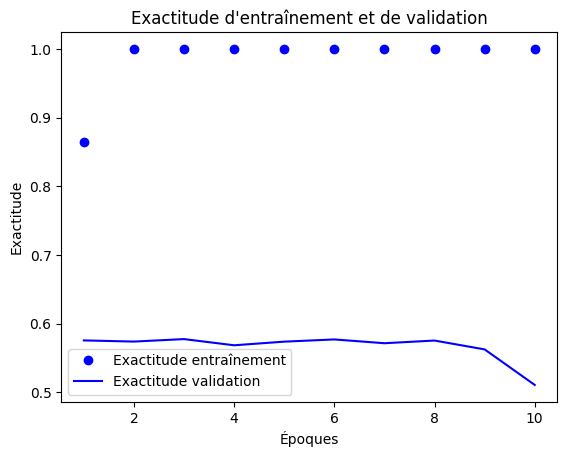

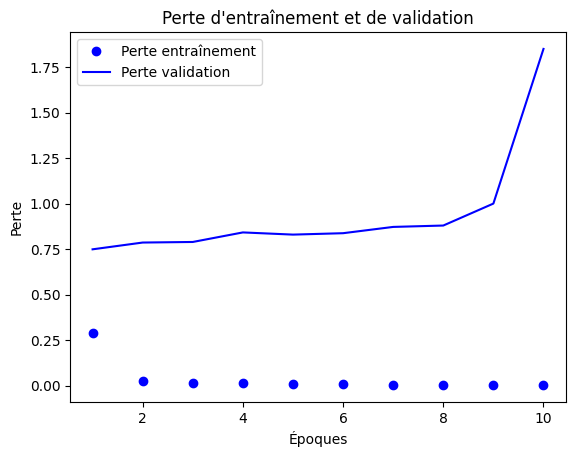

In [21]:
import matplotlib.pyplot as plt

# Récupération des valeurs de l'historique d'entraînement
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Définition des époques
epochs = range(1, len(acc) + 1)

# Tracé de l'exactitude d'entraînement et de validation
plt.plot(epochs, acc, 'bo', label='Exactitude entraînement')
plt.plot(epochs, val_acc, 'b', label='Exactitude validation')
plt.title('Exactitude d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Exactitude')
plt.legend()

plt.figure()

# Tracé de la perte d'entraînement et de validation
plt.plot(epochs, loss, 'bo', label='Perte entraînement')
plt.plot(epochs, val_loss, 'b', label='Perte validation')
plt.title('Perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


## sans embeding pre-entrainée

In [22]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - acc: 0.5336 - loss: 0.6918 - val_acc: 0.5028 - val_loss: 0.6932
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - acc: 0.9918 - loss: 0.6006 - val_acc: 0.5001 - val_loss: 0.6943
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - acc: 0.9973 - loss: 0.4863 - val_acc: 0.5090 - val_loss: 0.6973
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - acc: 0.9950 - loss: 0.3249 - val_acc: 0.5124 - val_loss: 0.7073
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - acc: 0.9892 - loss: 0.2023 - val_acc: 0.5148 - val_loss: 0.7051
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - acc: 0.9963 - loss: 0.1136 - val_acc: 0.5128 - val_loss: 0.7136
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - acc: 0.9987 - loss: 0.0663 - val_acc: 0.5096 - val_loss: 0.7386
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - acc: 0.9973 - loss: 0.0467 - val_acc: 0.5130 - val_loss: 0.7284
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - acc: 1.0000 - loss: 

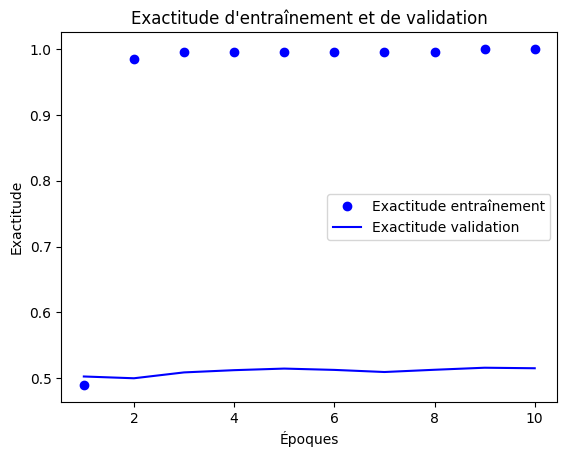

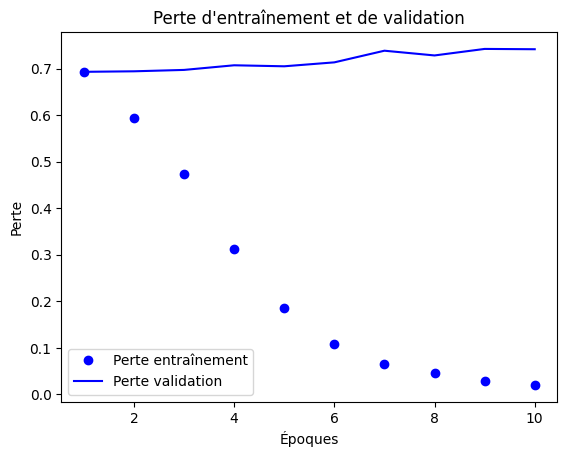

In [23]:
# Récupération des valeurs de l'historique d'entraînement
exactitude = history.history['acc']
exactitude_val = history.history['val_acc']
perte = history.history['loss']
perte_val = history.history['val_loss']

# Définition des époques
epoques = range(1, len(exactitude) + 1)

# Tracé de l'exactitude d'entraînement et de validation
plt.plot(epoques, exactitude, 'bo', label='Exactitude entraînement')
plt.plot(epoques, exactitude_val, 'b', label='Exactitude validation')
plt.title('Exactitude d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Exactitude')
plt.legend()

plt.figure()

# Tracé de la perte d'entraînement et de validation
plt.plot(epoques, perte, 'bo', label='Perte entraînement')
plt.plot(epoques, perte_val, 'b', label='Perte validation')
plt.title('Perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()

In [31]:
# 📁 Chemin du dossier de base sur Kaggle
base = "/kaggle/input/imdb-review"
test_dir = os.path.join(base, "aclImdb", "test")

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname.endswith(".txt"):
            with open(os.path.join(dir_name, fname), encoding="utf-8") as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

# 🔹 Conversion en séquences numériques
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


In [35]:
model.load_weights('pre_trained_glove_model.weights.h5')
model.evaluate(x_test, y_test)

 14/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.8425 - loss: 0.2765  

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.7587 - loss: 0.6620


[1.5367428064346313, 0.5079200267791748]

In [37]:
# Exemple de texte pour la prédiction
texte = "This is one of the first films I can remember, or maybe the first one. Exactly the beautiful kind of film than introduce a kid, sweetly, into the world of violence and addictions were we live. A little bit of Babe, Casino and Constantine, all this well mixed into a carton, and we get this. I don't know if its truly rated for kids, but I think it was very cool, very funny and interesting. I hate when a film (spescially a carton)can have a good end and its ruining because every character must have a happy end, even if it sounds weird (Im not a bitter person).But this was OK, he simply goes heaven and they let it in that way.<br /><br />All this is just a critic, Its a good movie an something new. very touching and I gotta go"

# Paramètres de prétraitement (les mêmes que ceux utilisés pour entraîner le modèle)
max_words = 10000
maxlen = 100

# Initialisation du tokenizer avec le même nombre de mots
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts([texte])  # Fit uniquement sur le texte d'exemple pour obtenir les séquences

# Conversion du texte en séquences de tokens
sequence = tokenizer.texts_to_sequences([texte])

# Remplissage de la séquence pour qu'elle ait la même longueur que celle utilisée pour l'entraînement
data = pad_sequences(sequence, maxlen=maxlen)

# Supposons que 'model' est votre modèle déjà entraîné
prediction = model.predict(data)

# Affichage de la prédiction
print("Texte :", texte)
print("Prédiction :", prediction)


probability = prediction[0][0]
if probability >= 0.5:
    sentiment = "positif"
else:
    sentiment = "négatif"

# Affichage de la prédiction
print("Texte :", texte)
print("Prédiction (probabilité de positivité) :", probability)
print("Sentiment :", sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Texte : This is one of the first films I can remember, or maybe the first one. Exactly the beautiful kind of film than introduce a kid, sweetly, into the world of violence and addictions were we live. A little bit of Babe, Casino and Constantine, all this well mixed into a carton, and we get this. I don't know if its truly rated for kids, but I think it was very cool, very funny and interesting. I hate when a film (spescially a carton)can have a good end and its ruining because every character must have a happy end, even if it sounds weird (Im not a bitter person).But this was OK, he simply goes heaven and they let it in that way.<br /><br />All this is just a critic, Its a good movie an something new. very touching and I gotta go
Prédiction : [[0.00120765]]
Texte : This is one of the first films I can remember, or maybe the first one. Exactly the beautiful kind of film than introduce a kid, sweetly, into the world of violence and addictions were w